In [1]:
import pandas as pd
import os
import os.path as osp
from sklearn.cluster import MiniBatchKMeans

In [2]:
# Methods for nucleotides manipulations
nucleotides = "ACGT"

def kmers_dic(n, choice=nucleotides):
    return {a: 0.0 for a in combinaisons(choice, n)}

def combinaisons(combi, n, instances=nucleotides):
    if n == 1:
        return combi
    else:
        return [f"{a}{n}" for a in combinaisons(combi, n-1) for n in instances]

In [3]:
path = "/mnt/data/Segmentation/k3_s50000/kmer_counts/all-counts.k3_s50000_oplant-vertebrate.csv"
path_allcounts = "/mnt/data/Segmentation/k3_s50000/kmer_counts/"

In [4]:
dtype = {
    "taxon": int,
    "category": str,
    "start": int,
    "end": int,
    "name": str,
    "description": str,
    "fna_path": str,
}
for kmer in combinaisons(nucleotides, 4):
    dtype[kmer] = float

In [5]:
col_kmers = combinaisons(nucleotides, 3)

In [6]:
n_clusters = 10
chunksize = 10000

In [33]:
df = pd.read_csv(path, dtype=dtype, usecols=col_kmers)
ml_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=3, batch_size=chunksize, max_iter=100)
ml_model.fit(df)
ml_model.cluster_centers_

array([[ 256.46865989,  490.24555789,  474.97327184,  266.64086442,
         387.72323787,  658.48490361, 1254.05935146,  248.5027098 ,
         369.64079649, 1042.79182078,  560.28870337,  248.34764723,
         161.83997826,  921.96710497,  591.30288643,  267.09322776,
         416.3720128 ,  772.77837744,  860.88774324,  592.27045938,
         569.91280325,  645.36647243, 1953.95136698,  558.83460395,
        1942.23868148, 3069.27787926, 1949.0111034 , 1253.84604701,
         139.65006567,  744.41352033,  862.78635588,  471.88883018,
         745.71564439, 1024.19874398,  746.15561359,  921.43227759,
        1143.20151417, 1839.62139008, 3066.92074395, 1043.1488957 ,
         584.7992331 , 1838.29288507,  643.01700608,  656.85185157,
         260.99570508, 1023.10768255,  771.89961655,  490.47216226,
          69.77322202,  261.55201461,  139.05296569,  161.85643333,
         541.47109796,  584.58938573, 1939.44115427,  368.25395148,
         540.82901073, 1142.528034  ,  570.64699

In [9]:
ml_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=3, batch_size=chunksize, max_iter=100)
for partial_df in pd.read_csv(path, chunksize=chunksize, dtype=dtype, usecols=col_kmers):
    ml_model.partial_fit(partial_df)
ml_model.cluster_centers_

array([[ 826.35560265,  703.79123164,  652.28852328,  594.33024577,
         535.22524947,  844.59155849,  767.33624573,  419.024277  ,
         546.46958445, 1015.71082995,  693.45506098,  419.01026749,
         476.90067449,  900.85467292,  761.69603506,  594.48777488,
         726.94130555,  734.889997  , 1191.79965121,  761.10045736,
         988.91555022,  717.74070844, 1252.05903516,  693.60767578,
         931.01818465, 1533.87591241, 1251.37852259,  766.87643791,
         256.39637808,  575.16266862, 1192.70167698,  651.8888998 ,
         803.75837915,  690.69933821,  575.02229049,  901.48261804,
        1074.16848956, 1413.69866257, 1533.28841356, 1016.69274346,
         676.82950083, 1413.75402499,  718.12004527,  844.26555715,
         436.4607722 ,  690.97831586,  735.49303566,  702.7394842 ,
         419.71135545,  436.79306223,  255.53082556,  477.02505659,
         816.430322  ,  676.28953386,  930.46705511,  546.82705234,
         816.6505359 , 1074.51054467,  990.01746

In [ ]:
chunksize = 1000
for partial_df in pd.read_csv(path, chunksize=chunksize, dtype=dtype):
    ml_model.partial_fit(partial_df)
ml_model.cluster_centers_

In [29]:
partial_df.sample()

,AAAA,AAAC,AAAG,AAAT,AACA,AACC,AACG,AACT,AAGA,AAGC,...,TTCG,TTCT,TTGA,TTGC,TTGG,TTGT,TTTA,TTTC,TTTG,TTTT
990067,370,333,293,349,406,291,258,208,254,195,...,302,314,325,259,134,322,336,517,370,569


In [14]:
partial_df.dtypes[:10]

taxon           int64
category       object
start           int64
end             int64
name           object
description    object
fna_path       object
AAAA            int64
AAAC            int64
AAAG            int64
dtype: object

# Iter through all .pd files

In [7]:
from pathlib import Path
from tqdm.notebook import tqdm

In [8]:
path_counts = "/mnt/data/Segmentation/k3_s50000/kmer_counts/counts.k3_s50000/"

In [9]:
chunksize = 10000

In [10]:
def counts_buffer(path_counts, chunksize=10000):
    buffer = []
    rows = 0
    
    for path in Path(path_counts).rglob("*/*.pd"):
        df = pd.read_pickle(path)
        rows += df.shape[0]
        buffer.append(df)

        if rows > chunksize:
            df_concat = pd.concat(buffer, ignore_index=True)
            yield df_concat.iloc[:chunksize,:]
            buffer = [df_concat.iloc[chunksize:, :]]
            rows -= chunksize

In [11]:
def counts_buffer(path_counts, chunksize=10000, usecols=col_kmers):
    buffer = []
    rows = 0
    
    for path in Path(path_counts).rglob("*/*.pd"):
        df = pd.read_pickle(path)[col_kmers]
        add_rows = df.shape[0]
        
        if rows + add_rows > chunksize:
            split_row = chunksize - rows
            buffer.append(df.iloc[:split_row, :])
            yield pd.concat(buffer, ignore_index=True)
            buffer = [df.iloc[split_row:, :]]
            rows = add_rows - split_row
        
        else:
            buffer.append(df)
            rows += add_rows
            
    # last part
    yield pd.concat(buffer, ignore_index=True)

In [12]:
# %%timeit
i = 0
ml_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=3, batch_size=chunksize, max_iter=100)
for partial_df in tqdm(counts_buffer(path_counts, chunksize=chunksize, usecols=col_kmers)):
    pass
#     ml_model.partial_fit(partial_df)
ml_model.cluster_centers_

KeyboardInterrupt: 

In [15]:
# %%timeit
i = 0
ml_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=3, batch_size=chunksize, max_iter=100)
for partial_df in tqdm(counts_buffer(path_counts, chunksize=chunksize, usecols=col_kmers)):
    ml_model.partial_fit(partial_df)
ml_model.cluster_centers_

array([[ 826.26104183,  703.81436666,  652.28391389,  594.35989996,
         535.16860636,  844.61814632,  767.28966079,  419.03442361,
         546.43378943, 1015.77796774,  693.45555254,  419.02211543,
         476.92831111,  900.90021197,  761.69480238,  594.51853734,
         726.90024085,  734.84263329, 1191.88833698,  761.09855201,
         988.92333239,  717.72983244, 1252.08809209,  693.60520282,
         930.97936316, 1533.81924719, 1251.40682234,  766.83227733,
         256.39374599,  575.12132011, 1192.7887511 ,  651.88417843,
         803.80791512,  690.63606855,  574.98206045,  901.53071845,
        1074.16630761, 1413.68826998, 1533.23237667, 1016.76065197,
         676.84584462, 1413.74465885,  718.11185362,  844.29562716,
         436.48332823,  690.91797247,  735.44966703,  702.76448708,
         419.75106996,  436.81406632,  255.53064336,  477.0519011 ,
         816.47972415,  676.30772163,  930.42927277,  546.78983117,
         816.70294622, 1074.50870698,  990.02574

In [16]:
partial_df

,AAA,AAC,AAG,AAT,ACA,ACC,ACG,ACT,AGA,AGC,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,954,530,667,671,669,411,457,485,447,533,...,442,543,551,690,717,827,602,806,814,1072
1,817,522,585,564,552,380,471,382,460,419,...,407,435,518,599,528,697,413,593,619,787
2,796,464,649,610,626,413,493,533,576,539,...,575,592,594,729,730,745,540,893,827,1016
3,933,621,838,673,704,409,623,417,621,541,...,437,430,666,752,744,741,447,584,675,787
4,832,585,814,602,720,469,624,496,649,608,...,543,522,729,790,696,814,479,689,736,832
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1166,527,648,374,782,767,1114,310,717,616,...,1179,596,422,1148,1018,704,142,396,870,1120
9996,1081,523,587,512,675,777,1055,381,611,609,...,1478,627,495,1070,944,663,192,520,883,1122
9997,1197,537,611,514,781,685,966,340,651,636,...,1439,646,429,1101,936,766,198,513,886,1164
9998,1136,551,606,480,750,721,1152,325,681,628,...,1402,611,451,1156,923,712,190,473,863,1006


# Trying threading

In [13]:
import concurrent.futures
import threading
import logging
import queue

In [14]:
format = "%(asctime)s: %(message)s"
logging.basicConfig(format=format, level=logging.INFO,
                    datefmt="%H:%M:%S")
logging.getLogger().setLevel(logging.INFO)

## Heat maps and profilers

In [75]:
%load_ext line_profiler

In [104]:
%lprun -f counts_buffer counts_buffer()

In [82]:
%load_ext heat

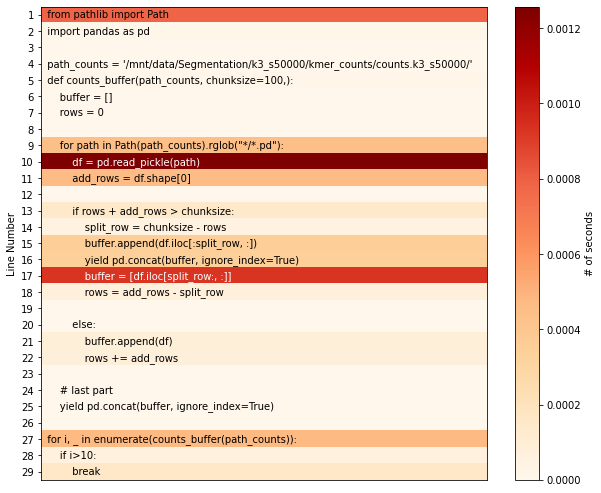

In [93]:
%%heat
from pathlib import Path
import pandas as pd

path_counts = '/mnt/data/Segmentation/k3_s50000/kmer_counts/counts.k3_s50000/'
def counts_buffer(path_counts, chunksize=100,):
    buffer = []
    rows = 0
    
    for path in Path(path_counts).rglob("*/*.pd"):
        df = pd.read_pickle(path)
        add_rows = df.shape[0]
        
        if rows + add_rows > chunksize:
            split_row = chunksize - rows
            buffer.append(df.iloc[:split_row, :])
            yield pd.concat(buffer, ignore_index=True)
            buffer = [df.iloc[split_row:, :]]
            rows = add_rows - split_row
        
        else:
            buffer.append(df)
            rows += add_rows
            
    # last part
    yield pd.concat(buffer, ignore_index=True)
    
for i, _ in enumerate(counts_buffer(path_counts)):
    if i>10:
        break

## From counts into chunks

Dead lock, couldn't debug :/

In [20]:
def add_path(qpath, event, path_counts='/mnt/data/Segmentation/k3_s50000/kmer_counts/counts.k3_s50000/'):
    total = sum(1 for _ in Path(path_counts).rglob("*/*.pd"))
    for i, path in enumerate(Path(path_counts).rglob("*/*.pd")):
        qpath.put(path)
        qpath.task_done()
        print("p", end="")
        if i > 1000:
            break
        
    event.set()

In [17]:
def pkl_loader(qpath, k, e_path, qpkl, e_loaders, col_kmers=col_kmers):
    # Continue as long as the path generator adds stuff
    while not e_path.is_set() or not qpath.empty():
        print("in while")
        path = qpath.get()
        qpath.task_done()
        print("got path" + path)
        df = pd.read_pickle(path)[col_kmers]
        print("df loaded")
        qpkl.put(df)
        print("read pkl")
    # announce that this worker finished
    print("finished")
    e_loaders[k].set()

In [18]:
def pkl_concat(qpkl, e_loaders, qchunk, e_concat):
    buffer = []
    rows = 0
    
    while not qpkl.empty() or not all((e.is_set() for e in e_loaders)):
        print("concatenatooor")
        
        df = qpkl.get()
        print("got ONE pkl !")
        qpkl.task_done()
        add_rows = df.shape[0]
        
        if rows + add_rows > chunksize:
            split_row = chunksize - rows
            buffer.append(df.iloc[:split_row, :])
            print("add chunk")
            qchunk.put(pd.concat(buffer, ignore_index=True))
            buffer = [df.iloc[split_row:, :]]
            rows = add_rows - split_row
        
        else:
            print("waiting for more pkl")
            buffer.append(df)
            rows += add_rows
            
    print("end")
    # last part
    qchunk.put(pd.concat(buffer, ignore_index=True))
    e_concat.set()

Dead lock somewhere, can't fine :/ 

In [ ]:
jobs = 4
loaders_n = max(1, jobs-2)
# One thread filling path queue, set the event when done
q_path = queue.Queue(50)
e_path = threading.Event()
# multiple threads to load the pkls 
e_loaders = [threading.Event() for i in range(loaders_n)]
q_pkl = queue.Queue(10)
# One thread to pkl into chunks
q_chunk = queue.Queue(10)
e_concat = threading.Event()
# One thread or process to train the minikm

with concurrent.futures.ThreadPoolExecutor(max_workers=jobs) as executor:
    executor.submit(add_path, q_path, e_path)
    for k in range(loaders_n):
        print(f"launch pkl loader {k}")
        executor.submit(pkl_loader, q_path, k, e_path, q_pkl, e_loaders)
    print(f"launch concatenator")
    executor.submit(pkl_concat, q_pkl, e_loaders, q_chunk, e_concat)

## chunks into minikm

In [62]:
class Pipeline(queue.Queue):
    def __init__(self):
        super().__init__(maxsize=10)

    def get_message(self, name):
        logging.debug("%s:about to get from queue", name)
        value = self.get()
        logging.info("%s: queue size: %d", name, pipeline.qsize())
        return value

    def set_message(self, value, name):
        logging.debug("%s:about to add to queue", name)
        self.put(value)
        logging.info("%s: queue size: %d", name, pipeline.qsize())

In [63]:
def producer(pipeline, event):
    """Pretend we're getting a message from the network."""
    for i, chunk in tqdm(enumerate(counts_buffer(path_counts, chunksize=chunksize, usecols=col_kmers))):
        pipeline.set_message(chunk, f">>>{i:>6}   ")
        
        if i>=10:
            break

    # Send a sentinel message to tell consumer we're done
    pipeline.set_message("finished", ">>>finish   ")

In [64]:
def consumer(pipeline, event):
    """Pretend we're saving a number in the database."""
    i = 0
    ml_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=3, batch_size=chunksize, max_iter=100)
    
    while not event.is_set() or not pipeline.empty():
        partial_df = pipeline.get_message(f"   {i:>6}>>>")
        ml_model.partial_fit(partial_df)
        i += 1
    return ml_model

In [65]:
pipeline = Pipeline()
event = threading.Event()
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
        executor.submit(producer, pipeline, event)
        result = executor.submit(consumer, pipeline, event)
    

20:37:34: >>>     0   : queue size: 1
20:37:34:         0>>>: queue size: 0
20:37:39: >>>     1   : queue size: 1
20:37:39:         1>>>: queue size: 0
20:37:42: >>>     2   : queue size: 1
20:37:42:         2>>>: queue size: 0
20:37:45: >>>     3   : queue size: 1
20:37:45:         3>>>: queue size: 0
20:37:47: >>>     4   : queue size: 1
20:37:47:         4>>>: queue size: 0
20:37:50: >>>     5   : queue size: 1
20:37:50:         5>>>: queue size: 0
20:37:53: >>>     6   : queue size: 1
20:37:53:         6>>>: queue size: 0
20:37:56: >>>     7   : queue size: 1
20:37:56:         7>>>: queue size: 0
20:37:59: >>>     8   : queue size: 1
20:37:59:         8>>>: queue size: 0
20:38:02: >>>     9   : queue size: 1
20:38:02:         9>>>: queue size: 0
20:38:05: >>>    10   : queue size: 1
20:38:05:        10>>>: queue size: 0
20:38:05: >>>finish   : queue size: 1
20:38:05:        11>>>: queue size: 0


In [ ]:
event.set()

In [28]:
result.cluster_centers_

AttributeError: 'Future' object has no attribute 'cluster_centers_'

# Multiprocessing version

In [47]:
from multiprocessing import Process, Queue, cpu_count
import random
import time

In [66]:
def serve(queue):
    for i, chunk in tqdm(enumerate(counts_buffer(path_counts, chunksize=chunksize, usecols=col_kmers))):
        queue.put(chunk)
    queue.put(None)

In [59]:
def work(work_id, queue):
    i = 0
    ml_model = MiniBatchKMeans(n_clusters=n_clusters, random_state=3, batch_size=chunksize, max_iter=100)
    
    while True:
        partial_df = queue.get()
        if partial_df is None:
            break
        ml_model.partial_fit(partial_df)
        i += 1
        
    print(f"worker : {work_id}")
    queue.put(None)
    return ml_model

In [60]:
class Manager:
    def __init__(self):
        self.queue = Queue(10)
        self.NUMBER_OF_PROCESSES = 2 # cpu_count()

    def start(self):
        print(f"starting {self.NUMBER_OF_PROCESSES} workers")
        self.workers = [Process(target=work, args=(i, self.queue,))
                        for i in range(self.NUMBER_OF_PROCESSES)]
        for w in self.workers:
            w.start()

        serve(self.queue)

    def stop(self):
        self.queue.put(None)
        for i in range(self.NUMBER_OF_PROCESSES):
            self.workers[i].join()
        self.queue.close()

In [61]:
Manager().start()

starting 2 workers


Process Process-7:
Process Process-8:
Traceback (most recent call last):
Traceback (most recent call last):


KeyboardInterrupt: 

  File "/home/ubuntu/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/home/ubuntu/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-59-059172a9d9cf>", line 6, in work
    partial_df = queue.get()
  File "<ipython-input-59-059172a9d9cf>", line 6, in work
    partial_df = queue.get()
  File "/home/ubuntu/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 94, in get
    res = self._recv_bytes()
  File "/home/ubuntu/.pyenv/versions/3.7.3/lib/python3.7/multiprocessing/queues.py", line 93, in get
    with self._rlock:
  File "/home/ubuntu/.pyenv

In [66]:
path_refseq = "/mnt/data/NCBI/20190704/refseq/"
kindgoms = "archaea,bacteria,fungi,protozoa,viral".split(",")
match = "*/*.fna"

In [67]:
files = []
for cat in tqdm(kindgoms):
    for path in tqdm(Path(path_refseq, cat).glob(match)):
        files.append(path.as_posix())

In [79]:
path.relative_to(path_refseq).as_posix()

'viral/GCF_900156925.1/GCF_900156925.1_BTP1_v2_genomic.fna'

In [76]:
os.chdir

'/mnt/data/NCBI/20190704/refseq/archaea/GCF_000006175.1/GCF_000006175.1_ASM617v2_genomic.fna'

In [69]:
found = ",".join(files)

In [74]:
cmd = "centrifuge-build -p 16 " \
        "--conversion-table /mnt/data/Segmentation/no-binning/oplant-vertebrate/kraken2/k35_l31_s7/seqid2taxid.map " \
        "--taxonomy-tree /mnt/ssd50/taxonomy/nodes.dmp " \
        "--name-table /mnt/ssd50/taxonomy/names.dmp " \
        + found + \
        "/mnt/data/Segmentation/no-binning/oplant-vertebrate/centrifuge/bac+v+a+f"

In [75]:
cmd

'centrifuge-build -p 16 --conversion-table /mnt/data/Segmentation/no-binning/oplant-vertebrate/kraken2/k35_l31_s7/seqid2taxid.map --taxonomy-tree /mnt/ssd50/taxonomy/nodes.dmp --name-table /mnt/ssd50/taxonomy/names.dmp /mnt/data/NCBI/20190704/refseq/archaea/GCF_000006175.1/GCF_000006175.1_ASM617v2_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000006805.1/GCF_000006805.1_ASM680v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000007005.1/GCF_000007005.1_ASM700v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000007065.1/GCF_000007065.1_ASM706v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000007225.1/GCF_000007225.1_ASM722v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000007305.1/GCF_000007305.1_ASM730v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000008265.1/GCF_000008265.1_ASM826v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_000008645.1/GCF_000008645.1_ASM864v1_genomic.fna,/mnt/data/NCBI/20190704/refseq/archaea/GCF_00

In [46]:
# %%timeit
i = 0
for df in tqdm(counts_buffer(path_counts, chunksize=chunksize)):
    i += 1
    if i > 5:
        break

In [103]:
df

,taxon,category,start,end,name,description,fna_path,AAA,AAC,AAG,...,TCG,TCT,TGA,TGC,TGG,TGT,TTA,TTC,TTG,TTT
0,395960,complete genome,5250000,5300000,NC_011004.1,|kraken:taxid|395960|s:5250000-e:5299999|NC_01...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,302,548,540,...,1709,508,672,961,703,429,144,789,611,303
1,395960,complete genome,5300000,5350000,NC_011004.1,|kraken:taxid|395960|s:5300000-e:5349999|NC_01...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,273,511,576,...,1701,449,612,1015,684,380,91,699,539,248
2,395960,complete genome,5350000,5400000,NC_011004.1,|kraken:taxid|395960|s:5350000-e:5399999|NC_01...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,254,532,538,...,1722,427,674,958,700,389,76,699,542,230
3,395960,complete genome,5400000,5450000,NC_011004.1,|kraken:taxid|395960|s:5400000-e:5449999|NC_01...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,218,476,465,...,1726,443,668,1037,716,389,88,641,535,209
4,395960,complete genome,5450000,5500000,NC_011004.1,|kraken:taxid|395960|s:5450000-e:5499999|NC_01...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,191,470,413,...,1823,537,665,1070,759,476,87,808,732,249
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,429009,complete genome,0,50000,NC_013385.1,|kraken:taxid|429009|s:0-e:49999|NC_013385.1 A...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,661,527,1178,...,601,683,549,812,1287,274,425,826,548,707
9996,429009,complete genome,50000,100000,NC_013385.1,|kraken:taxid|429009|s:50000-e:99999|NC_013385...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,693,446,1105,...,570,774,472,930,1417,331,495,857,657,934
9997,429009,complete genome,100000,150000,NC_013385.1,|kraken:taxid|429009|s:100000-e:149999|NC_0133...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,791,505,1175,...,614,751,596,798,1132,358,480,897,633,970
9998,429009,complete genome,150000,200000,NC_013385.1,|kraken:taxid|429009|s:150000-e:199999|NC_0133...,/ssd1500/NCBI/20190704/refseq/bacteria/GCF_000...,725,487,1170,...,557,657,500,822,1252,276,471,858,553,1002
